# Exploratory data analysis of TCGA mutation data

In [1]:
import os

import numpy
import pandas
import seaborn

%matplotlib inline

## Read TCGA datasets

In [2]:
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
mutation_df = pandas.read_table(path, index_col=0)
mutation_df.columns.name = 'entrez_gene_id'
mutation_df.shape

(7306, 21940)

In [3]:
path = os.path.join('data', 'samples.tsv')
sample_df = pandas.read_table(path)
sample_df.head(2)

,sample_id,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
0,TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,Brain,Male,78.0,1.0,448.0,NaN,NaN
1,TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,Brain,Female,62.0,1.0,76.0,NaN,NaN


## Distribution of mutations counts for genes

In [4]:
gene_df = mutation_df.sum(axis='rows').rename('n_mutations').reset_index()
gene_df['n_mutations_log1p'] = numpy.log1p(gene_df.n_mutations)
gene_df.head(2)

,entrez_gene_id,n_mutations,n_mutations_log1p
0,1,30,3.433987
1,2,130,4.875197


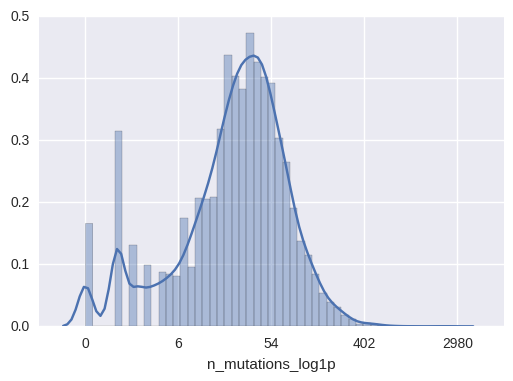

In [5]:
ax = seaborn.distplot(gene_df.n_mutations_log1p)
xticks = ax.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = ax.set_xticklabels(xticklabels)

In [6]:
sum(gene_df.n_mutations == 0)

572

## Distribution of mutations counts for samples

In [7]:
sample_df = sample_df.merge(
    mutation_df.sum(axis='columns').rename('n_mutations').reset_index()
)
sample_df['n_mutations_log1p'] = numpy.log1p(sample_df.n_mutations)
sample_df.head(2)

,sample_id,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free,n_mutations,n_mutations_log1p
0,TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,Brain,Male,78.0,1.0,448.0,NaN,NaN,39,3.688879
1,TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,Brain,Female,62.0,1.0,76.0,NaN,NaN,33,3.526361


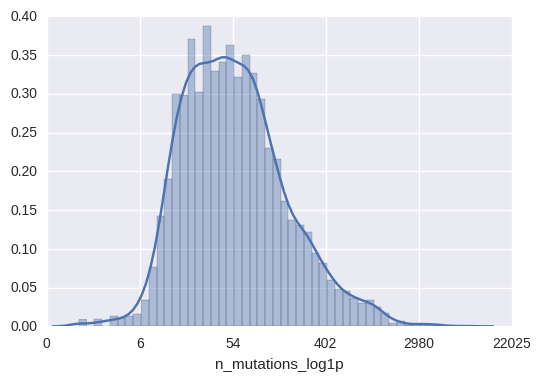

In [8]:
# Mutations per sample
ax = seaborn.distplot(sample_df.n_mutations_log1p)
xticks = ax.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = ax.set_xticklabels(xticklabels)

## Diagnosis age versus mutation count for samples

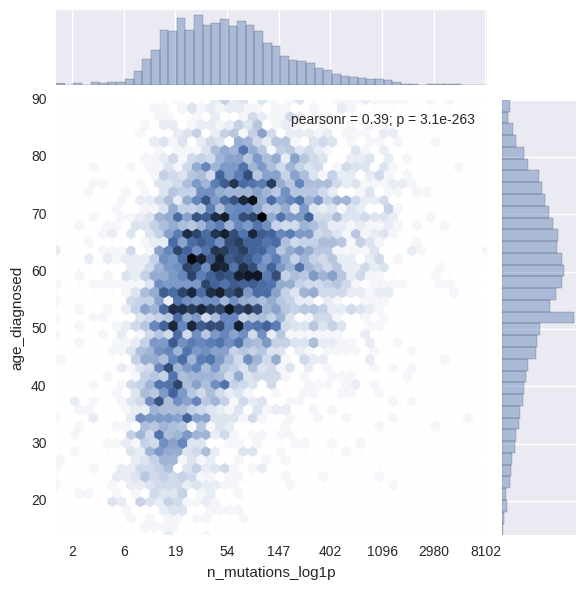

In [9]:
grid = seaborn.jointplot('n_mutations_log1p', 'age_diagnosed', data=sample_df, kind='hex')
xticks = grid.ax_marg_x.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = grid.ax_marg_x.set_xticklabels(xticklabels)

## Mutation frequency by disease

In [10]:
genes = mutation_df.columns.tolist()
verbose_mutation_df = sample_df.merge(mutation_df.reset_index())
mutation_freq_df = verbose_mutation_df.groupby('disease').apply(lambda df: df[genes].mean(axis='rows')).assign(
    n_mutations = verbose_mutation_df.groupby('disease').apply(len)
)
mutation_freq_df.iloc[:3, :3]

,1,2,3
disease,,,
adrenocortical cancer,0.000000,0.000000,0.0
bladder urothelial carcinoma,0.010256,0.038462,0.0
brain lower grade glioma,0.001938,0.003876,0.0


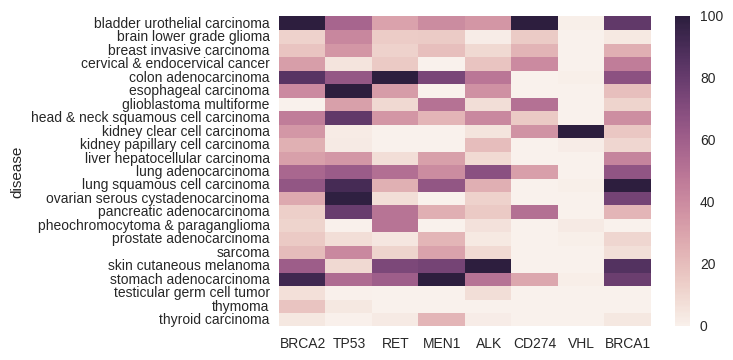

In [11]:
gene_subset = {
    '7157': 'TP53', # tumor protein p53
    '7428': 'VHL', # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1', # BRCA1, DNA repair associated
    '675': 'BRCA2', # BRCA2, DNA repair associated
    '238': 'ALK', # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1', # menin 1
    '5979': 'RET', # ret proto-oncogene 
}
plot_df = (mutation_freq_df
    .query("n_mutations > 100")
    [list(gene_subset)]
    .rename(columns=gene_subset)
)

# Convert to percent of max mutation rate for gene
plot_df = 100 * plot_df.divide(plot_df.max())
ax = seaborn.heatmap(plot_df)